In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64" 
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [3]:
import pyspark
sc = pyspark.SparkContext(appName="FraudDetection")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/26 11:57:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("FraudDetection") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()
spark

In [5]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import avg, stddev, count, hour, col, max
from pyspark.ml import Pipeline
from sklearn.manifold import TSNE
import seaborn as sns
from pyspark.sql.functions import desc  # This line is essential for sorting
import json
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth
import networkx as nx
from pyspark.sql.functions import hour, dayofweek, month, to_timestamp

warnings.filterwarnings("ignore")
data_path='/kaggle/input/transactions-data-big-data/Transactions Data/Transactions Data'

# Read the data

In [6]:
from pyspark.sql import functions as F

# Load the users data
users_df = spark.read.csv(f"{data_path}/users.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the columns to double type
users_df = users_df.withColumn("per_capita_income", F.regexp_replace("per_capita_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("yearly_income", F.regexp_replace("yearly_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("total_debt", F.regexp_replace("total_debt", "[\$,]", "").cast("double"))

print(users_df.count())
# Check the count of rows
users_df.show(3)

1219
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|client_id|current_age|retirement_age|birth_year|birth_month|gender|            address|latitude|longitude|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|     1645|         62|            65|      1957|         11|Female|    58 Federal Lane|   41.47|   -81.85|          29692.0|      60541.0|  160456.0|         716|               3|
|     1591|         58|            66|      1961|          6|Female|   2200 Third Drive|   48.28|  -122.62|          16537.0|      33717.0|   58236.0|         698|               6|
|     1959|         46|            59|      1973|          4|  Male|8750 Lake Boulevard|  

In [7]:
from pyspark.sql import functions as F

# Read the transactions data
transactions_df = spark.read.csv(f"{data_path}/transactions.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'amount' column to double type
transactions_df = transactions_df.withColumn("amount", F.regexp_replace("amount", "[\$,]", "").cast("double"))

# Check the count of rows
print(transactions_df.count())
transactions_df.show(3)

8914963
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|     id|               date|client_id|card_id|amount|         use_chip|merchant_id|  merchant_city| mcc|  errors|target|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|7475341|2010-01-01 00:27:00|     1797|   1127| 43.33|Swipe Transaction|      33326|        Kahului|4121|No Error|    No|
|7475347|2010-01-01 00:36:00|      114|   3398| -64.0|Swipe Transaction|      61195|North Hollywood|5541|No Error|    No|
|7475378|2010-01-01 01:19:00|     1575|   2112| 17.14|Swipe Transaction|      29232|         Osprey|4121|No Error|    No|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
only showing top 3 rows



In [8]:
# Read the cards data
cards_df = spark.read.csv(f"{data_path}/cards.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'credit_limit' column to double type
cards_df = cards_df.withColumn("credit_limit", F.regexp_replace("credit_limit", "[\$,]", "").cast("double"))

# Check the count of rows
cards_df.count()

4514

# EDA

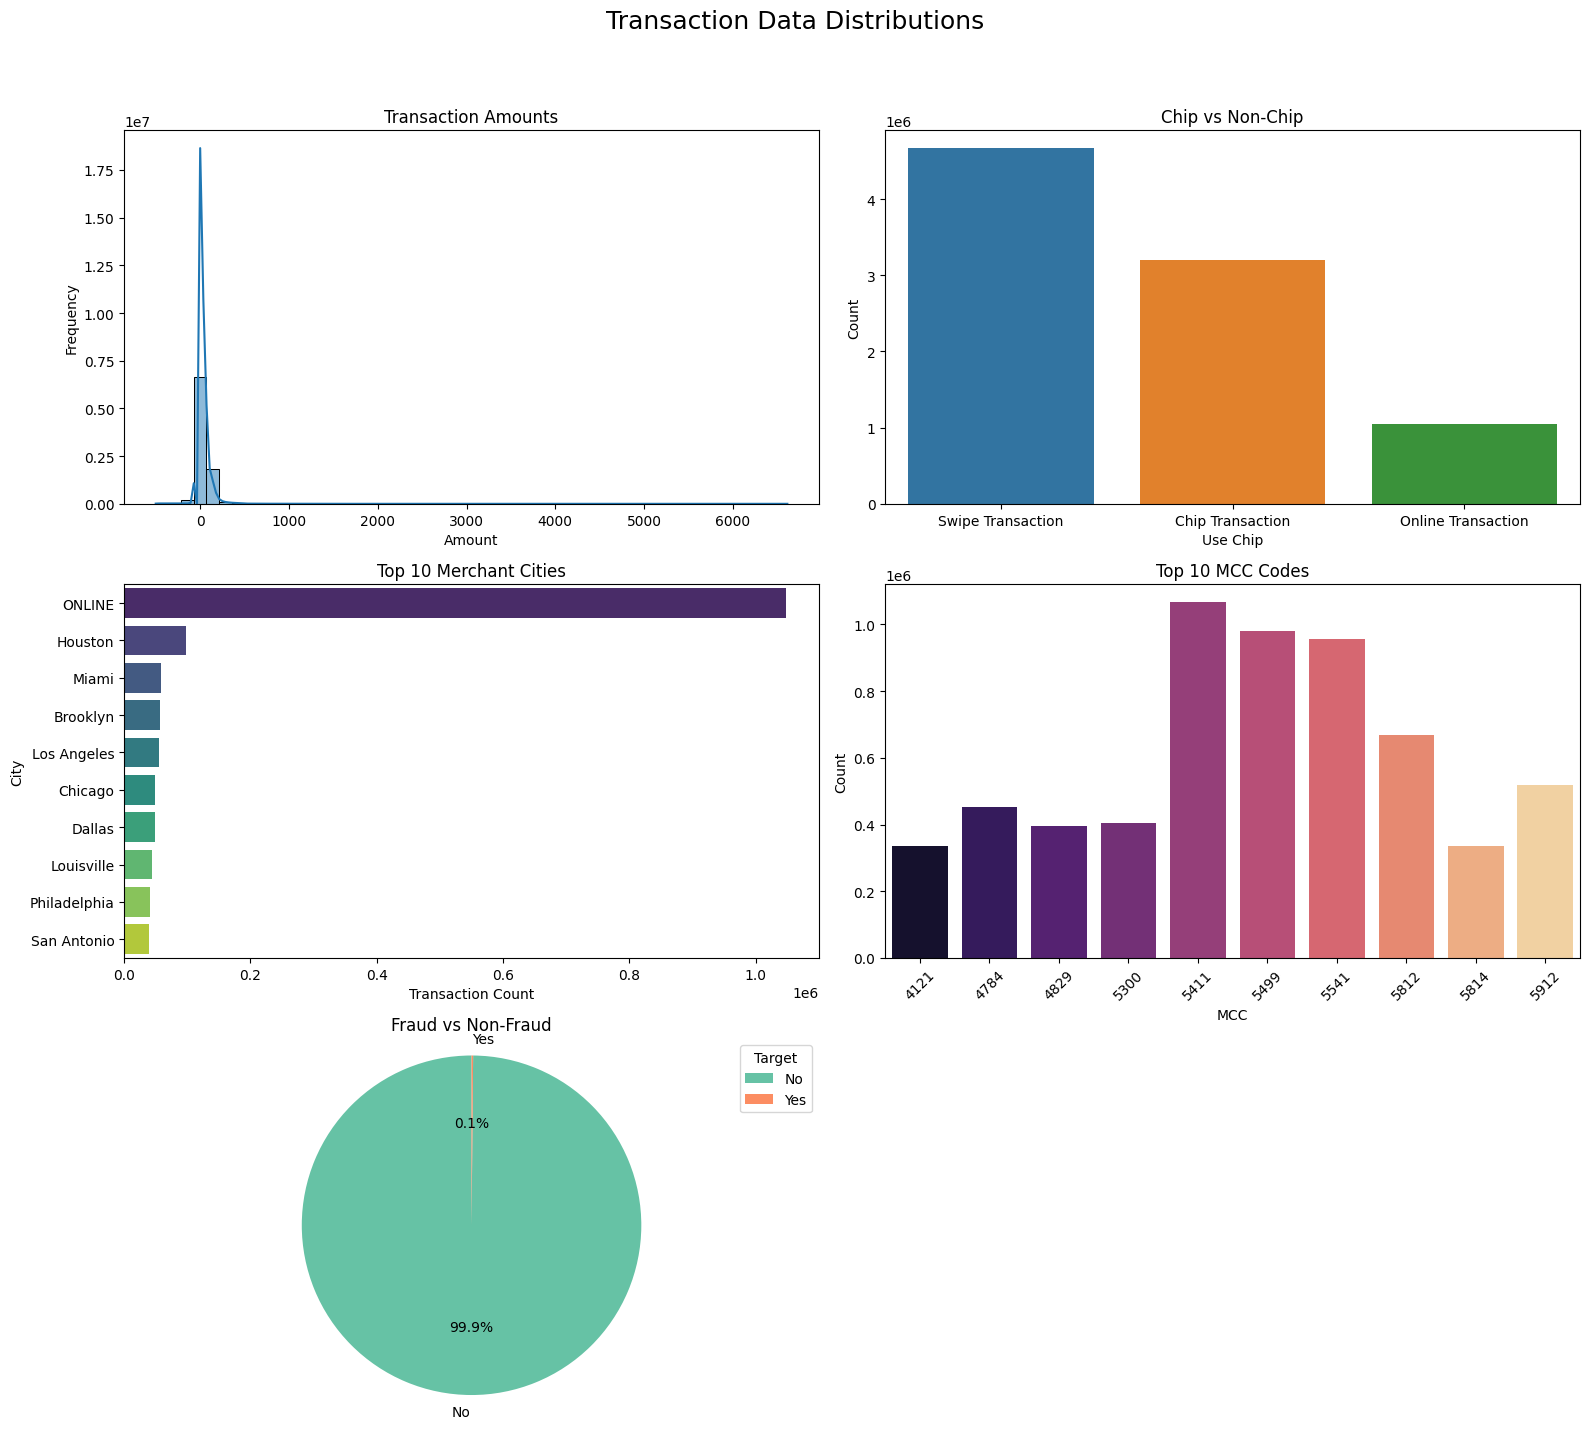

In [16]:


# Convert required PySpark DataFrames to pandas
amount_df = transactions_df.select("amount").toPandas()
chip_df = transactions_df.groupBy("use_chip").count().toPandas()
top_cities = transactions_df.groupBy("merchant_city").count().orderBy("count", ascending=False).limit(10).toPandas()
mcc_df = transactions_df.groupBy("mcc").count().orderBy("count", ascending=False).limit(10).toPandas()
target_df = transactions_df.groupBy("target").count().toPandas()

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))
fig.suptitle('Transaction Data Distributions', fontsize=18)

# 1. Distribution of Amounts
sns.histplot(amount_df["amount"], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Transaction Amounts")
axes[0, 0].set_xlabel("Amount")
axes[0, 0].set_ylabel("Frequency")

# 2. Use Chip vs No
sns.barplot(data=chip_df, x="use_chip", y="count", ax=axes[0, 1])
axes[0, 1].set_title("Chip vs Non-Chip")
axes[0, 1].set_xlabel("Use Chip")
axes[0, 1].set_ylabel("Count")

# 3. Top 10 Merchant Cities
sns.barplot(data=top_cities, x="count", y="merchant_city", palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title("Top 10 Merchant Cities")
axes[1, 0].set_xlabel("Transaction Count")
axes[1, 0].set_ylabel("City")

# 4. Top 10 MCC Codes
sns.barplot(data=mcc_df, x="mcc", y="count", palette="magma", ax=axes[1, 1])
axes[1, 1].set_title("Top 10 MCC Codes")
axes[1, 1].set_xlabel("MCC")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis='x', rotation=45)
# 5. Fraud vs Non-Fraud Pie Chart
fraud_counts = transactions_df.groupBy("target").count().toPandas()

# Create the pie chart
axes[2, 0].pie(fraud_counts["count"], labels=fraud_counts["target"], autopct='%1.1f%%', 
               colors=sns.color_palette("Set2", len(fraud_counts)), startangle=90)

# Set title and labels
axes[2, 0].set_title("Fraud vs Non-Fraud")
axes[2, 0].axis('equal')  # Equal aspect ratio ensures that pie chart is circular.

# Optionally, you can display the count as a legend
axes[2, 0].legend(fraud_counts["target"], title="Target", loc="best")

# Hide the unused 6th plot (bottom-right)
axes[2, 1].axis('off')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Analysis of Common Transaction Types 

In [17]:
with open("/kaggle/input/transactions-data-big-data/mcc_codes.json", "r") as f:
    mcc_dict = json.load(f)

# Convert to list of dicts
mcc_list = [{"mcc": int(k), "description": v} for k, v in mcc_dict.items()]

# Create Spark DataFrame
mcc_df = spark.createDataFrame(mcc_list)
mcc_df.printSchema()
transactions_df.printSchema()

transactions_df = transactions_df.join(mcc_df, on="mcc", how="left")

root
 |-- description: string (nullable = true)
 |-- mcc: long (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)
 |-- target: string (nullable = true)



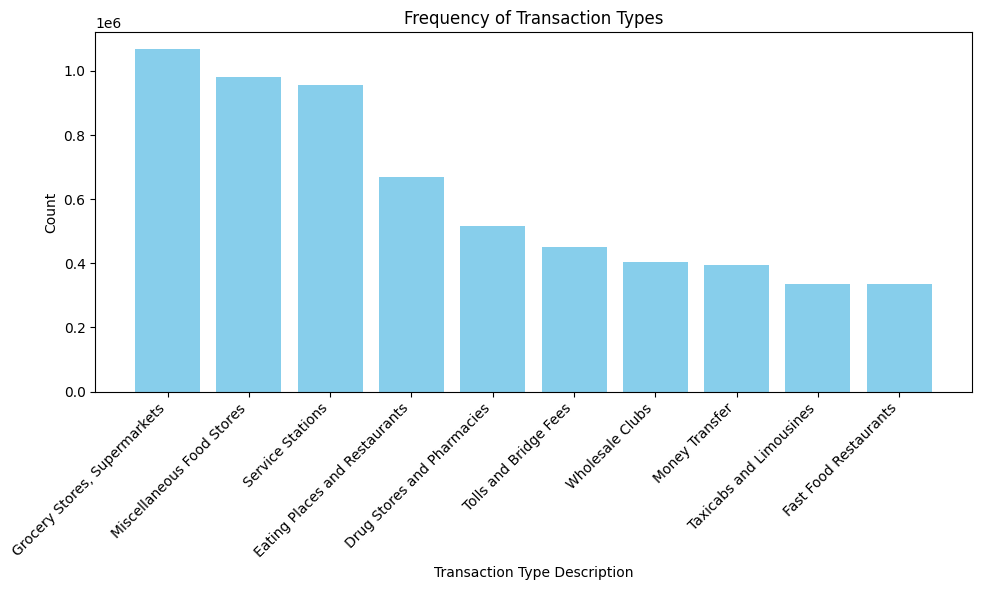

In [18]:

transaction_type_counts = transactions_df.groupBy("description").count()

#  Sort to find the most frequent transaction types
sorted_types = transaction_type_counts.orderBy(desc("count")).limit(10)
pandas_df = sorted_types.toPandas()

# Histogram (Bar Chart)
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['description'], pandas_df['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Transaction Type Description")
plt.ylabel("Count")
plt.title("Frequency of Transaction Types")
plt.tight_layout()
plt.show()


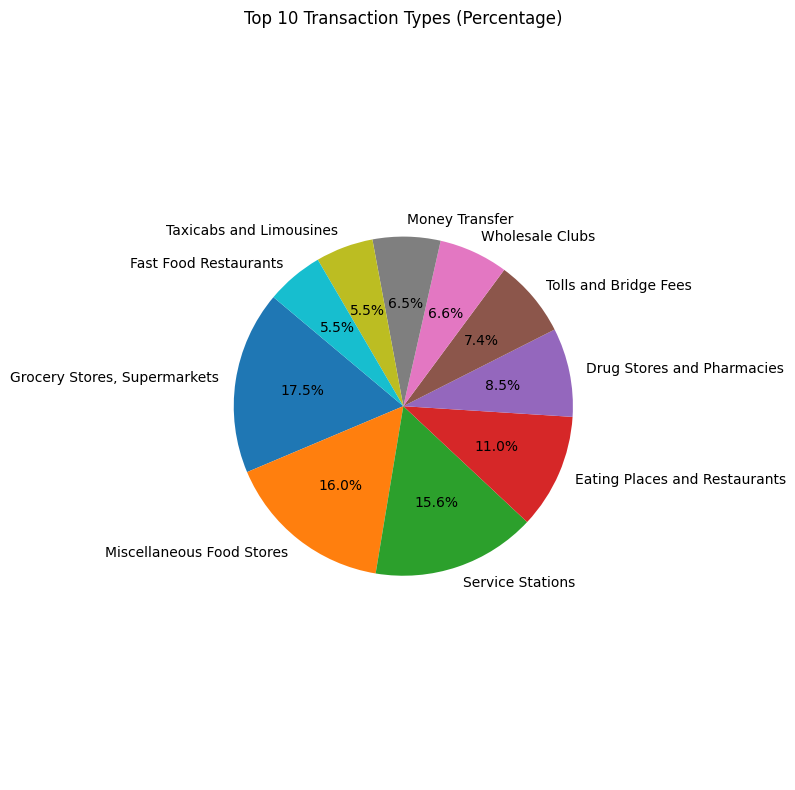

In [19]:
# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(pandas_df['count'], labels=pandas_df['description'], autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Transaction Types (Percentage)")
plt.axis('equal')  # Equal aspect ratio ensures a circle.
plt.tight_layout()
plt.show()

In [20]:
sorted_types.printSchema()

root
 |-- description: string (nullable = true)
 |-- count: long (nullable = false)



In [21]:
##find which transcation types are more likely to be fraudulent.

# Get total count and fraud count per transaction type
transaction_fraud_stats = transactions_df.filter("target == 'Yes'") \
    .groupBy("description") \
    .agg(
        F.count("*").alias("fraud_count")
    )


In [22]:

# transaction_fraud_stats.show()
# Calculate fraud rate without join
transaction_with_fraud_rate = sorted_types.join(transaction_fraud_stats, on="description", how="left") \
    .withColumn("fraud_rate", F.col("fraud_count") / F.col("count")*100).orderBy(desc("fraud_rate"))

# Show sorted results by fraud rate
print("fraud rate in top 10 transcation types")
transaction_with_fraud_rate.orderBy(F.desc("fraud_rate")).show()

fraud rate in top 10 transcation types


+--------------------+-------+-----------+--------------------+
|         description|  count|fraud_count|          fraud_rate|
+--------------------+-------+-----------+--------------------+
|     Wholesale Clubs| 403343|        991| 0.24569659074286648|
|      Money Transfer| 394401|        725| 0.18382306332894693|
|Drug Stores and P...| 517400|        479| 0.09257827599536142|
|Taxicabs and Limo...| 335586|        300| 0.08939586275947149|
|Fast Food Restaur...| 334333|        235|  0.0702892026811592|
|Grocery Stores, S...|1066833|        425| 0.03983753783394402|
|Eating Places and...| 669808|        121|0.018064878293481117|
|    Service Stations| 955123|        168|  0.0175893576010629|
|Miscellaneous Foo...| 979396|        131|0.013375590670168145|
|Tolls and Bridge ...| 451814|       NULL|                NULL|
+--------------------+-------+-----------+--------------------+



In [24]:
transaction_with_fraud_rate = transaction_type_counts.join(transaction_fraud_stats, on="description", how="left") \
    .withColumn("fraud_rate", F.col("fraud_count") / F.col("count")*100).orderBy(desc("fraud_rate")).limit(10)

print("Most common types with fraud transcations")
transaction_with_fraud_rate.orderBy(F.desc("fraud_rate")).show()



Most common types with fraud transcations


+--------------------+-----+-----------+------------------+
|         description|count|fraud_count|        fraud_rate|
+--------------------+-----+-----------+------------------+
|        Cruise Lines|  276|        165| 59.78260869565217|
|Music Stores - Mu...|  204|         76|37.254901960784316|
|Miscellaneous Fab...|  245|         29| 11.83673469387755|
|Computers, Comput...| 1883|        204|10.833775889537971|
|Floor Covering St...|  222|         23| 10.36036036036036|
|Miscellaneous Met...|  256|         22|           8.59375|
|  Electronics Stores| 4689|        402| 8.573256557901471|
|Fabricated Struct...|  273|         22| 8.058608058608058|
|Precious Stones a...| 3525|        242| 6.865248226950355|
|Furniture, Home F...| 2600|        170| 6.538461538461539|
+--------------------+-----+-----------+------------------+



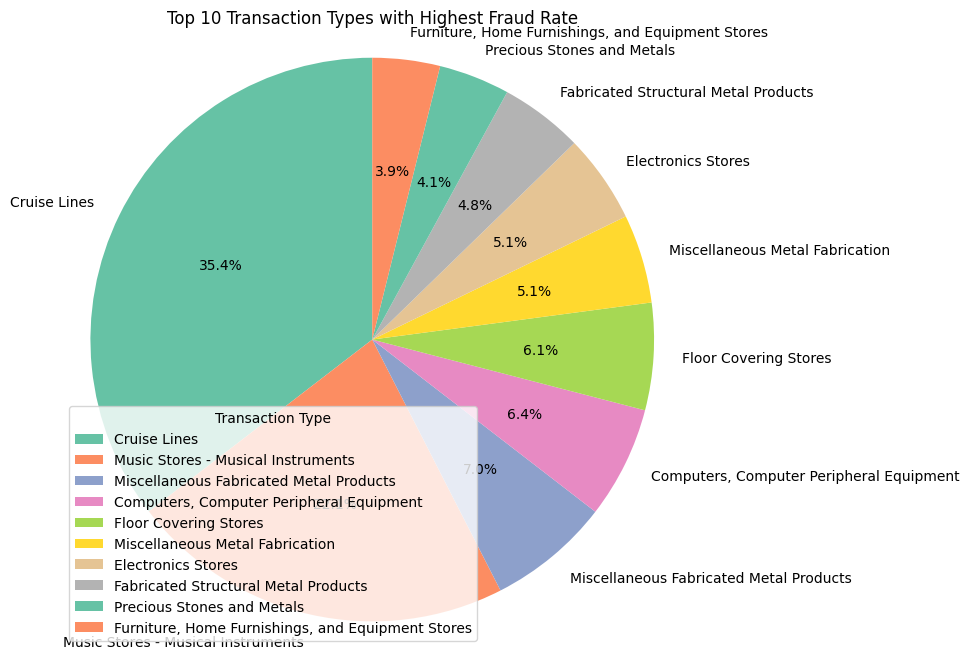

In [25]:
# Collect the data to a Pandas DataFrame
top_fraud_types = transaction_with_fraud_rate.toPandas()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_fraud_types["fraud_rate"], labels=top_fraud_types["description"], autopct='%1.1f%%', 
        colors=sns.color_palette("Set2", len(top_fraud_types)), startangle=90)

# Set title and labels
plt.title("Top 10 Transaction Types with Highest Fraud Rate")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.

# Optionally, you can add a legend to show the transaction type names
plt.legend(top_fraud_types["description"], title="Transaction Type", loc="best")

# Show the plot
plt.show()


# Association of Transaction Features

In [26]:
stats = transactions_df.select(
    F.mean("amount").alias("mean_amount"),
    F.stddev("amount").alias("stddev_amount")
).first()

mean_amount = stats["mean_amount"]
stddev_amount = stats["stddev_amount"]

In [28]:
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth

# Step 1: Bin the amount into categorical strings
transactions_fpgrowth_data = transactions_df.withColumn(
    "amount_flag", 
    F.when(F.col("amount") > mean_amount + stddev_amount, F.lit("High"))
     .when(F.col("amount") < mean_amount - stddev_amount, F.lit("Low"))
     .otherwise(F.lit("Medium"))
)


# Step 2: Select the relevant columns
transactions_fpgrowth_data = transactions_fpgrowth_data.select(
    "description", "merchant_city", "amount_flag"
)

# Step 3: Assemble the features array
transactions_fpgrowth_data = transactions_fpgrowth_data.withColumn(
    "features", 
    F.array("description", "merchant_city", "amount_flag")
)

# Step 4: Run FP-Growth
fpgrowth = FPGrowth(itemsCol="features", minSupport=0.01, minConfidence=0.1)
model = fpgrowth.fit(transactions_fpgrowth_data)


25/04/26 12:26:22 WARN MemoryStore: Not enough space to cache rdd_357_1 in memory! (computed 97.0 MiB so far)
25/04/26 12:26:22 WARN BlockManager: Persisting block rdd_357_1 to disk instead.
25/04/26 12:26:22 WARN MemoryStore: Not enough space to cache rdd_357_3 in memory! (computed 96.0 MiB so far)
25/04/26 12:26:22 WARN BlockManager: Persisting block rdd_357_3 to disk instead.
25/04/26 12:26:22 WARN MemoryStore: Not enough space to cache rdd_357_0 in memory! (computed 96.5 MiB so far)
25/04/26 12:26:22 WARN BlockManager: Persisting block rdd_357_0 to disk instead.
25/04/26 12:26:22 WARN MemoryStore: Not enough space to cache rdd_357_2 in memory! (computed 97.4 MiB so far)
25/04/26 12:26:22 WARN BlockManager: Persisting block rdd_357_2 to disk instead.
25/04/26 12:26:31 WARN MemoryStore: Not enough space to cache rdd_357_0 in memory! (computed 28.6 MiB so far)
25/04/26 12:26:31 WARN MemoryStore: Not enough space to cache rdd_357_4 in memory! (computed 11.9 MiB so far)
25/04/26 12:26:3

In [29]:
# Get the frequent itemsets 
frequent_itemsets = model.freqItemsets

frequent_itemsets.show(truncate=False)

#  Generate association rules from the frequent itemsets
association_rules = model.associationRules

# Show the association rules
association_rules.show(truncate=False)


+-----------------------------------------------+-------+
|items                                          |freq   |
+-----------------------------------------------+-------+
|[Telecommunication Services]                   |146244 |
|[Telecommunication Services, Medium]           |89767  |
|[Eating Places and Restaurants]                |669808 |
|[Eating Places and Restaurants, Medium]        |665771 |
|[Wholesale Clubs]                              |403343 |
|[Wholesale Clubs, Medium]                      |362848 |
|[Department Stores]                            |318511 |
|[Department Stores, Medium]                    |295270 |
|[Medium]                                       |7842885|
|[Money Transfer]                               |394401 |
|[Money Transfer, Medium]                       |336129 |
|[Drinking Places (Alcoholic Beverages)]        |166460 |
|[Drinking Places (Alcoholic Beverages), Medium]|166398 |
|[Grocery Stores, Supermarkets]                 |1066833|
|[Grocery Stor

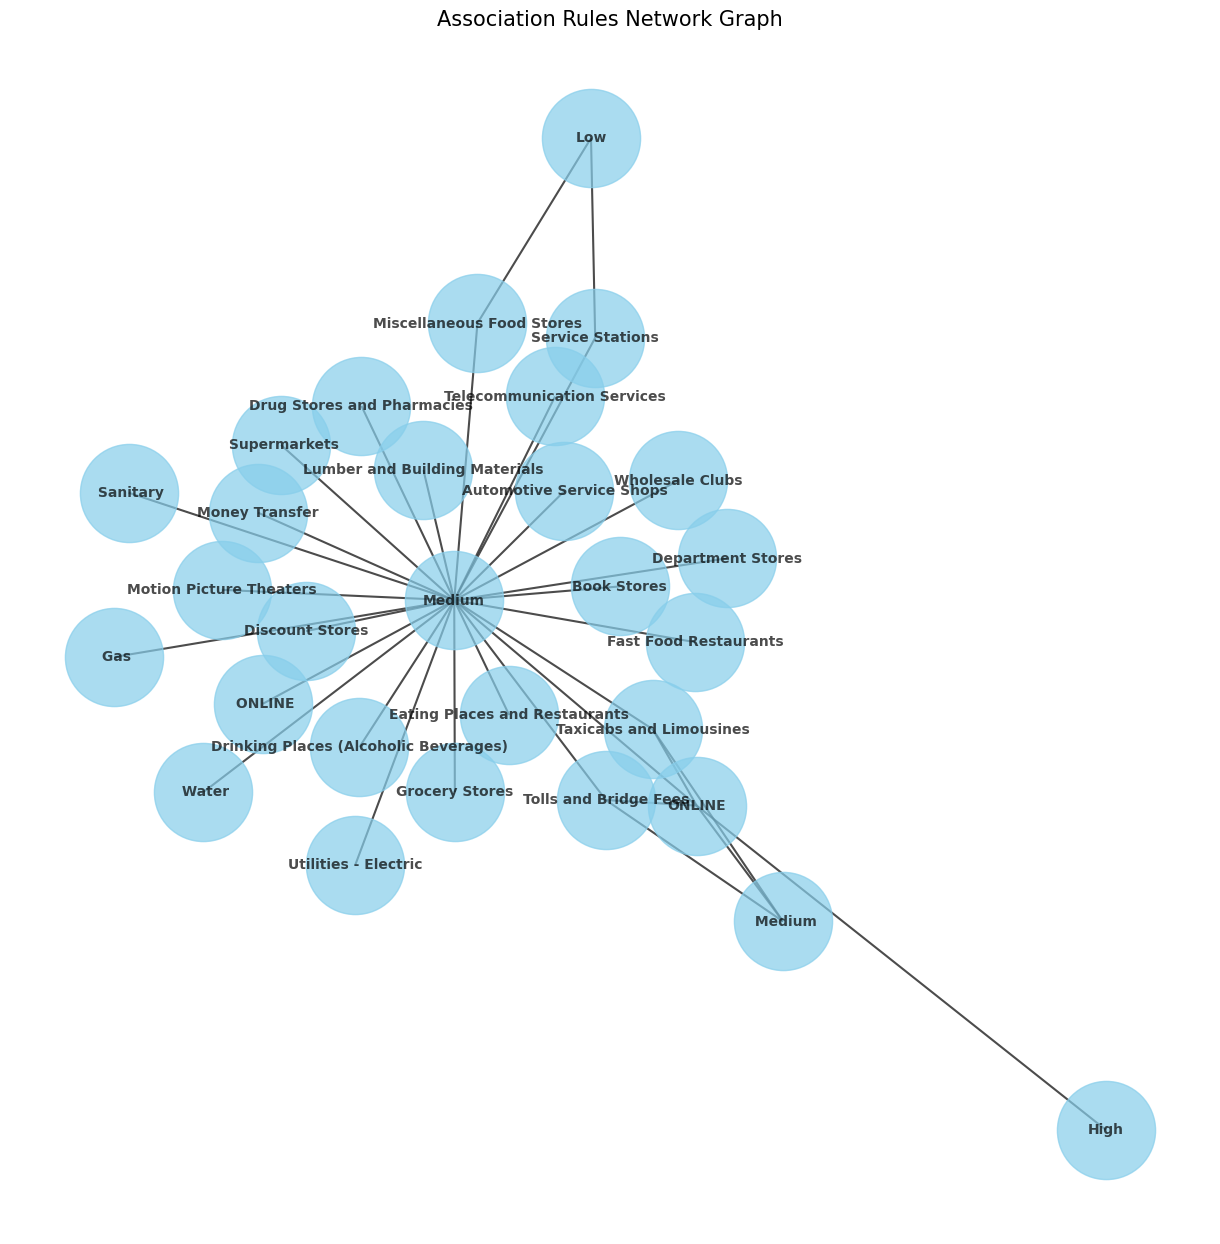

In [31]:
association_rules_df = association_rules.toPandas()

# Assuming association_rules DataFrame is loaded with 'antecedent', 'consequent', 'support', 'confidence', 'lift'
# Convert antecedent and consequent into list of items
association_rules_df['antecedent'] = association_rules_df['antecedent'].apply(lambda x: str(x).replace('[','').replace(']','').replace("'",'').split(","))
association_rules_df['consequent'] = association_rules_df['consequent'].apply(lambda x: str(x).replace('[','').replace(']','').replace("'",'').split(","))

# Initialize a graph
G = nx.Graph()

# Add edges with weights (support, confidence, or lift)
for idx, row in association_rules_df.iterrows():
    for antecedent_item in row['antecedent']:
        for consequent_item in row['consequent']:
            G.add_edge(antecedent_item, consequent_item, weight=row['confidence'])

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Position the nodes
nx.draw(G, pos, with_labels=True, node_size=5000, node_color='skyblue', font_size=10, font_weight='bold', width=1.5, alpha=0.7)
plt.title('Association Rules Network Graph', fontsize=15)
plt.show()


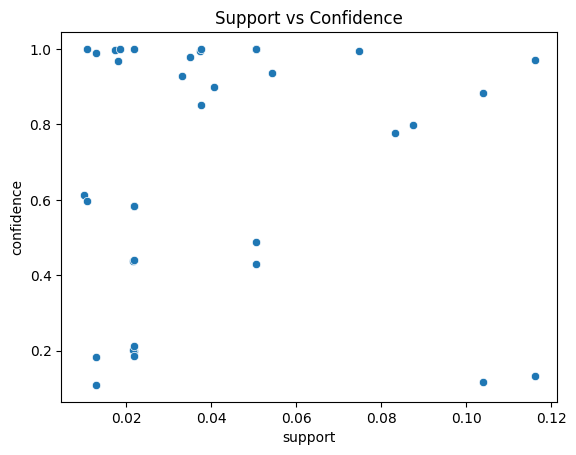

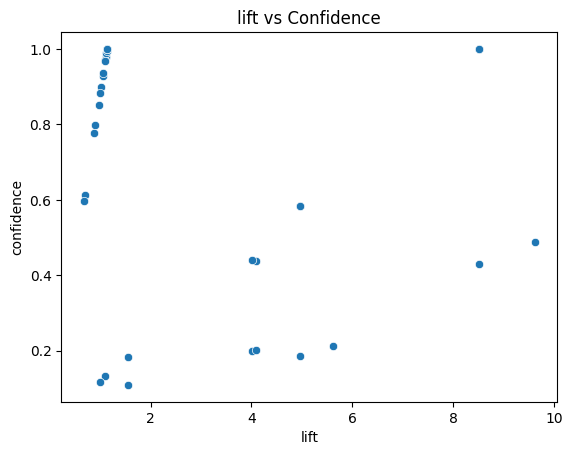

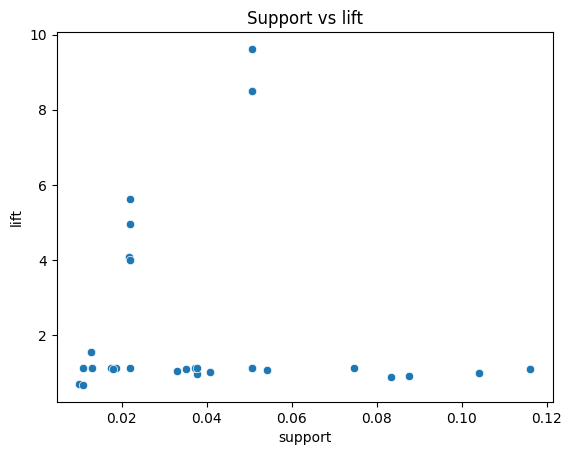

In [32]:

# Create a DataFrame for plotting
# association_rules_df = pd.DataFrame(association_rules)

sns.scatterplot(data=association_rules_df, x='support', y='confidence')
plt.title("Support vs Confidence")
plt.show()

sns.scatterplot(data=association_rules_df, x='lift', y='confidence')
plt.title("lift vs Confidence")
plt.show()

sns.scatterplot(data=association_rules_df, x='support', y='lift')
plt.title("Support vs lift")
plt.show()


- most rules have high confidence but low support meaning they are reliable but apply to small portion of total transcations


# Time-Based Transaction Behavior Analysis 

In [33]:
from pyspark.sql.functions import hour, dayofweek, month, year

# Extract time features
transactions_df1 = transactions_df.withColumn("hour", hour("date"))
transactions_df1 = transactions_df1.withColumn("day_of_week", dayofweek("date"))  # 1 = Sunday, 7 = Saturday
transactions_df1 = transactions_df1.withColumn("month", month("date"))
transactions_df1 = transactions_df1.withColumn("year", year("date"))

transactions_df1.show(10)


+----+-------+-------------------+---------+-------+------+------------------+-----------+-------------+--------+------+--------------------+----+-----------+-----+----+
| mcc|     id|               date|client_id|card_id|amount|          use_chip|merchant_id|merchant_city|  errors|target|         description|hour|day_of_week|month|year|
+----+-------+-------------------+---------+-------+------+------------------+-----------+-------------+--------+------+--------------------+----+-----------+-----+----+
|3780|7475460|2010-01-01 03:08:00|      957|   4532|-147.0| Swipe Transaction|      44795|   Marysville|No Error|    No|Computer Network ...|   3|          6|    1|2010|
|3780|7475464|2010-01-01 03:13:00|      957|   4532| 14.21| Swipe Transaction|      44795|   Marysville|No Error|    No|Computer Network ...|   3|          6|    1|2010|
|4121|7475341|2010-01-01 00:27:00|     1797|   1127| 43.33| Swipe Transaction|      33326|      Kahului|No Error|    No|Taxicabs and Limo...|   0|    

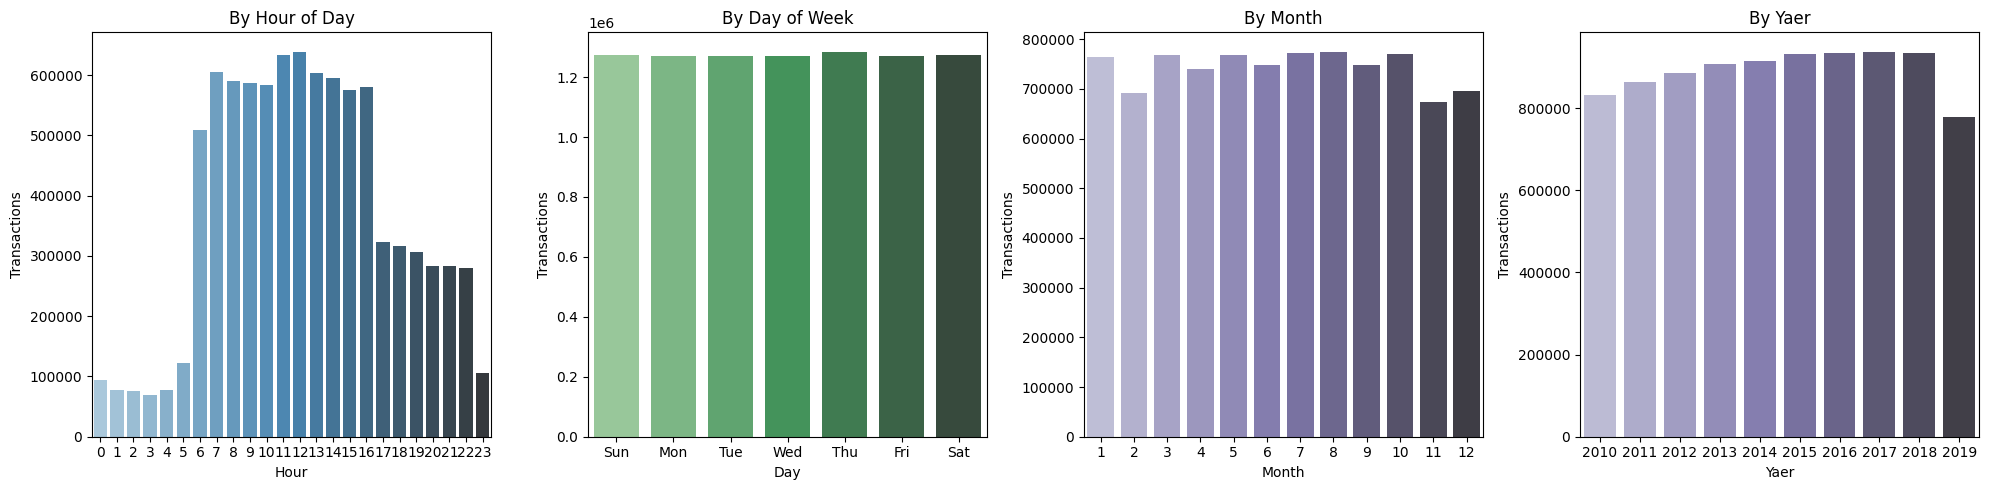

In [40]:
# hour_df = transactions_df1.groupBy("hour").count().orderBy("hour").toPandas()
# day_df = transactions_df1.groupBy("day_of_week").count().orderBy("day_of_week").toPandas()
# month_df = transactions_df1.groupBy("month").count().orderBy("month").toPandas()
# year_df = transactions_df1.groupBy("year").count().orderBy("year").toPandas()

day_labels = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
day_df["day_name"] = day_df["day_of_week"].map(day_labels)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Hour of day
sns.barplot(data=hour_df, x="hour", y="count", ax=axs[0], palette="Blues_d")
axs[0].set_title("By Hour of Day")
axs[0].set_xlabel("Hour")
axs[0].set_ylabel("Transactions")

# Day of week
sns.barplot(data=day_df, x="day_name", y="count", ax=axs[1], palette="Greens_d")
axs[1].set_title("By Day of Week")
axs[1].set_xlabel("Day")
axs[1].set_ylabel("Transactions")

# Month
sns.barplot(data=month_df, x="month", y="count", ax=axs[2], palette="Purples_d")
axs[2].set_title("By Month")
axs[2].set_xlabel("Month")
axs[2].set_ylabel("Transactions")


# Month
sns.barplot(data=year_df, x="year", y="count", ax=axs[3], palette="Purples_d")
axs[3].set_title("By Yaer")
axs[3].set_xlabel("Yaer")
axs[3].set_ylabel("Transactions")

plt.tight_layout()
plt.show()

# Transaction Error Rates 

+--------------------+-----+--------------------+
|errors              |count|error_rate          |
+--------------------+-----+--------------------+
|Insufficient Balance|87686|0.9835823210932003  |
|Bad PIN             |21488|0.24103296895343257 |
|Technical Glitch    |17776|0.19939510685574352 |
|Bad Card Number     |5235 |0.058721500021929426|
|Bad CVV             |4091 |0.04588914165992613 |
+--------------------+-----+--------------------+



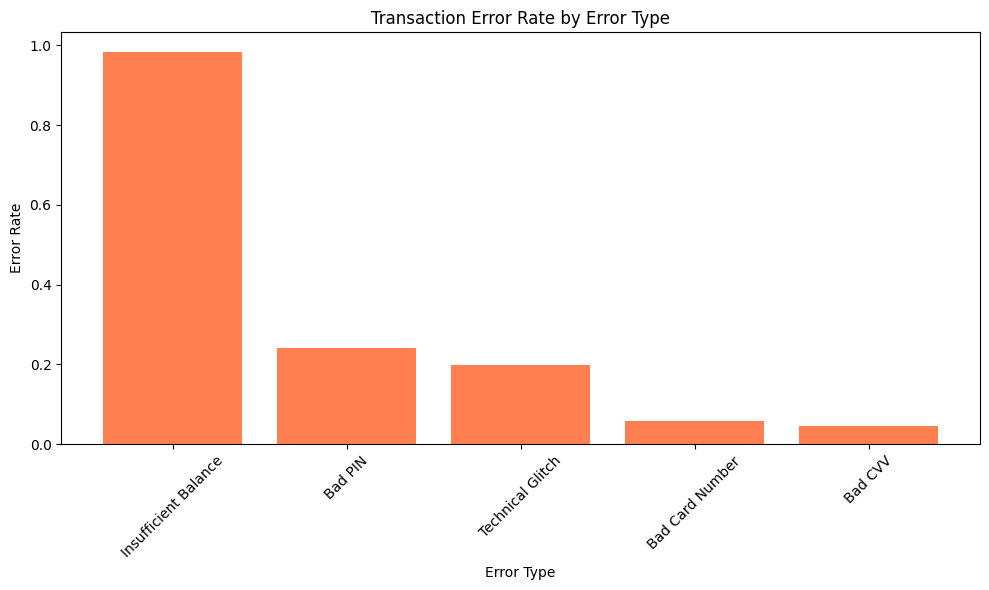

In [31]:
from pyspark.sql import functions as F

# 1. Total number of transactions
total_txns = transactions_df.count()

# 2. Count of each error type, excluding "No Error"
error_counts = transactions_df.filter(F.col("errors") != "No Error") \
                              .groupBy("errors") \
                              .count()

# 3. Calculate error rate
error_rates = error_counts.withColumn("error_rate", F.col("count") / total_txns*100)

# 4. Show top 5 error types by error rate
error_rates = error_rates.orderBy(F.desc("error_rate")).limit(5)

error_rates.show(truncate=False)

error_pd = error_rates.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(error_pd['errors'], error_pd['error_rate'], color='coral')
plt.title("Transaction Error Rate by Error Type")
plt.xlabel("Error Type")
plt.ylabel("Error Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:

errors_df = transactions_df.filter(F.col("errors") != "No Error")

error_merchant = errors_df.groupBy("errors", "merchant_id") \
                          .count() \
                          .orderBy(F.desc("count"))

# Show top 10 merchants with most errors
error_merchant.show(10, truncate=False)

fraud_error_counts = errors_df.filter(F.col("target") == "Yes") \
                              .groupBy("errors") \
                              .count() \
                              .withColumnRenamed("count", "fraud_count")

# === 3. Join with previous error_counts to compute fraud rate per error ===
error_fraud_analysis = error_counts.join(fraud_error_counts, on="errors", how="left") \
                                   .fillna(0, subset=["fraud_count"]) \
                                   .withColumn("fraud_rate_per_error", F.col("fraud_count") / F.col("count"))

# Sort by fraud rate
error_fraud_analysis.orderBy(F.desc("fraud_rate_per_error")).show(truncate=False)

+--------------------+-----------+-----+
|errors              |merchant_id|count|
+--------------------+-----------+-----+
|Insufficient Balance|27092      |9844 |
|Insufficient Balance|59935      |5669 |
|Insufficient Balance|61195      |4085 |
|Insufficient Balance|60569      |3263 |
|Insufficient Balance|22204      |2940 |
|Insufficient Balance|43293      |2901 |
|Insufficient Balance|26810      |1854 |
|Insufficient Balance|39021      |1701 |
|Insufficient Balance|20561      |1599 |
|Bad PIN             |27092      |1581 |
+--------------------+-----------+-----+
only showing top 10 rows



+---------------------------------------------------+-----+-----------+---------------------+
|errors                                             |count|fraud_count|fraud_rate_per_error |
+---------------------------------------------------+-----+-----------+---------------------+
|Bad CVV,Technical Glitch                           |5    |1          |0.2                  |
|Bad CVV,Insufficient Balance                       |40   |2          |0.05                 |
|Bad CVV                                            |4091 |139        |0.03397702273282816  |
|Bad Card Number,Insufficient Balance               |50   |1          |0.02                 |
|Bad Expiration                                     |4086 |54         |0.013215859030837005 |
|Bad Card Number                                    |5235 |59         |0.011270296084049666 |
|Bad PIN                                            |21488|112        |0.0052122114668652275|
|Bad PIN,Insufficient Balance                       |198  |1

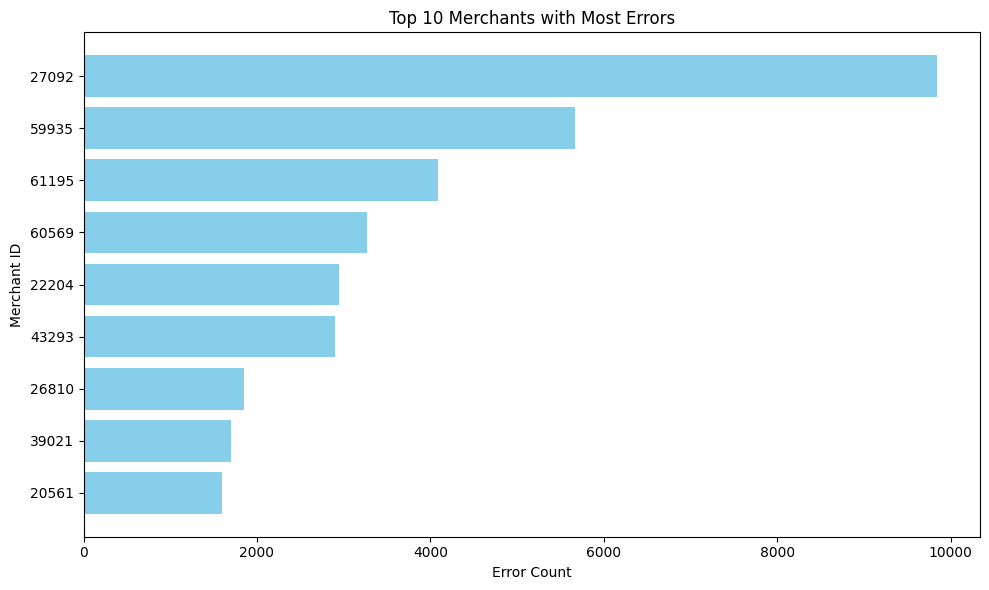

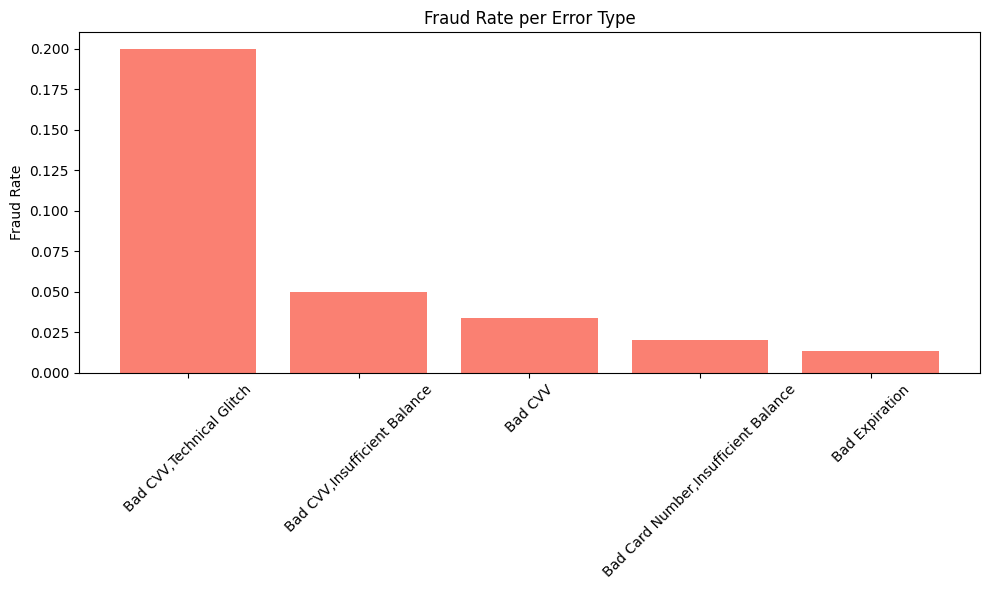

In [37]:

top_merchant_errors = error_merchant.limit(10).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(top_merchant_errors['merchant_id'].astype(str), top_merchant_errors['count'], color='skyblue')
plt.xlabel("Error Count")
plt.ylabel("Merchant ID")
plt.title("Top 10 Merchants with Most Errors")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

error_fraud_pd = error_fraud_analysis.orderBy(F.desc("fraud_rate_per_error")).limit(5).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(error_fraud_pd['errors'], error_fraud_pd['fraud_rate_per_error'], color='salmon')
plt.xticks(rotation=45)
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate per Error Type")
plt.tight_layout()
plt.show()
